# Housing Affordability 
- Ratio of median household income to median rent
- Using 2021 census data

In [11]:
import pandas as pd


In [12]:
def merge_on_suburb(column, data, destination):
    """ 
    A function to merge on suburb when they are of different forms
    Takes the average of combo suburbs - so only works for numeric data
    """
    # incoming dataset needs to have brackets/ extra info removed
    # also ensure lower case
    data["suburb"] = data["suburb"].str.replace(r"\s*\([^)]*\)", "", regex=True)
    data["suburb"] = data['suburb'].str.lower()

    # extra adjustments needed to match specific formatting
    data["suburb"] = data["suburb"].replace("brunswick west", "west brunswick")
    data["suburb"] = data["suburb"].replace("brunswick east", "east brunswick")
    data["suburb"] = data["suburb"].replace("st kilda east", "east st kilda")
    data["suburb"] = data["suburb"].replace("st kilda west", "west st kilda")
    data["suburb"] = data["suburb"].replace("hawthorn east", "east hawthorn")
    data["suburb"] = data["suburb"].replace("east bendigo", "bendigo east")

    data["suburb"] = data["suburb"].replace("mount martha", "mt martha")
    data["suburb"] = data["suburb"].replace("mount eliza", "mt eliza")

    data["suburb"] = data["suburb"].replace("wangaratta", "wanagaratta")
    data["suburb"] = data["suburb"].replace("newcomb", "newcombe")
    
    
    # First create conjoined suburbs
    # iterate through the suburbs 
    for suburb in destination["suburb"].unique():
        # check if we have a hyphen suburb needs to be averaged
        if "-" in suburb:
            to_avg = suburb.split("-")
            # take average of metric from each suburb
            if set(to_avg).issubset(set(data['suburb'])) == True:
                # we can  take an average
                # Filter to only those suburbs
                subset = data[data['suburb'].isin(to_avg)]
                
                # Compute the average population
                average_population = subset[column].mean()
                
                new_row = pd.DataFrame({
                    'suburb': [suburb], 
                    column: [average_population]
                })
                
                # Append to the other DataFrame
                data = pd.concat([data, new_row], ignore_index=True)
                                
    # now do a merge on suburb
    merged = pd.merge( destination, data, on='suburb', how='inner') 

    return merged
        

In [13]:
data_path = "../data/curated/rent_growth/panel_data.csv"
panel_data_1 = pd.read_csv(data_path)


# Use median stats to add median personal income
data_path = "../data/landing/median_stats.csv"
census_medians = pd.read_csv(data_path)
# Extract Median Household Income
subset = census_medians[census_medians["Statistic"] == "Median total household income ($/weekly)"]
subset = subset.rename(columns={"Value": 
                                "median_household_income"}).drop(columns=["Statistic"])
subset = subset.rename(columns={"Suburb": "suburb"})
panel_data_2 = merge_on_suburb("median_household_income", subset, panel_data_1)


# Extract Median Rent
subset_age = census_medians[census_medians["Statistic"] == "Median rent ($/weekly)(a)"]
subset_age = subset_age.rename(columns={"Value": 
                                "median_rent_census"}).drop(columns=["Statistic"])
subset_age = subset_age.rename(columns={"Suburb": "suburb"})
panel_data_3 = merge_on_suburb("median_rent_census", subset_age, panel_data_2)
print(panel_data_3)

             date  year  quarter  cpi  wpi  ppi  unemployment_rate     sfd  \
0      2000-03-01  2000        1  3.2  3.0  3.4           6.670933  5.9497   
1      2000-03-01  2000        1  3.2  3.0  3.4           6.670933  5.9497   
2      2000-03-01  2000        1  3.2  3.0  3.4           6.670933  5.9497   
3      2000-03-01  2000        1  3.2  3.0  3.4           6.670933  5.9497   
4      2000-03-01  2000        1  3.2  3.0  3.4           6.670933  5.9497   
...           ...   ...      ...  ...  ...  ...                ...     ...   
84973  2025-03-01  2025        1  2.3  3.3  3.7           4.544433  1.8019   
84974  2025-03-01  2025        1  2.3  3.3  3.7           4.544433  1.8019   
84975  2025-03-01  2025        1  2.3  3.3  3.7           4.544433  1.8019   
84976  2025-03-01  2025        1  2.3  3.3  3.7           4.544433  1.8019   
84977  2025-03-01  2025        1  2.3  3.3  3.7           4.544433  1.8019   

          gsp  state_final_demand  ...  net_overseas_migration 

In [14]:
# Merge with panel data for correct number of suburbs

affordability = panel_data_3[['suburb', 'median_rent_census','median_household_income']]
affordability = affordability.drop_duplicates(subset='suburb').reset_index(drop=True)
affordability['income_rent_ratio'] = affordability['median_rent_census'] / affordability['median_household_income']
print(affordability)
affordability.to_csv('../data/analysis/affordabilit.csv', index=False)

                                    suburb  median_rent_census  \
0    albert park-middle park-west st kilda          525.666667   
1                                   altona          385.000000   
2                                 armadale          421.000000   
3                 aspendale-chelsea-carrum          413.666667   
4                               bairnsdale          270.000000   
..                                     ...                 ...   
138                         west footscray          351.000000   
139                             whittlesea          347.000000   
140                           williamstown          450.000000   
141                                wodonga          280.000000   
142                      yarraville-seddon          461.000000   

     median_household_income  income_rent_ratio  
0                2450.666667           0.214499  
1                1826.000000           0.210843  
2                2193.000000           0.191974  
3      

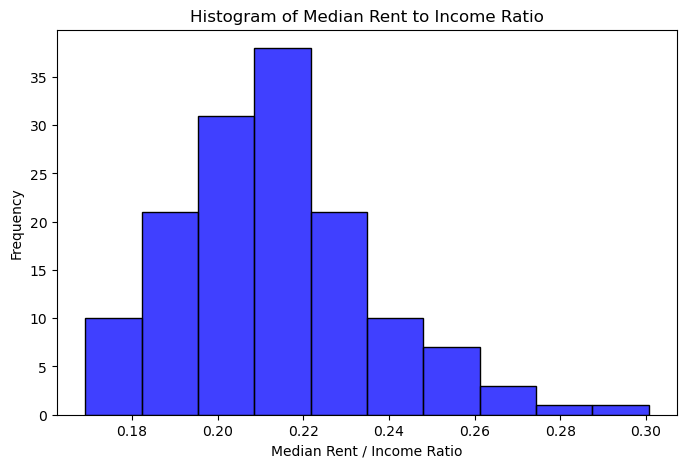

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(affordability['income_rent_ratio'], bins=10, color='blue')
plt.title('Histogram of Median Rent to Income Ratio')
plt.xlabel('Median Rent / Income Ratio')
plt.ylabel('Frequency')
plt.show()

In [ ]:
top_6 = affordability.nlargest(6, 'income_rent_ratio')
print(top_6)

                         suburb  median_rent_census  median_household_income  \
14                     box hill               381.0                   1267.0   
78                       melton               300.0                   1058.0   
125            thomastown-lalor               350.5                   1286.5   
27                  castlemaine               300.0                   1106.0   
31                      clayton               400.0                   1494.0   
17   broadmeadows-roxburgh park               360.5                   1390.0   

     income_rent_ratio  
14            0.300710  
78            0.283554  
125           0.272445  
27            0.271248  
31            0.267738  
17            0.259353  


In [ ]:
bottom_6 =  affordability.nsmallest(6, 'income_rent_ratio')
print(bottom_6)

                          suburb  median_rent_census  median_household_income  \
123                    swan hill          235.000000              1390.000000   
71          ivanhoe-ivanhoe east          440.500000              2604.500000   
91                       newtown          360.000000              2092.000000   
76                       malvern          450.000000              2606.000000   
49   eltham-research-montmorency          430.333333              2447.666667   
138               west footscray          351.000000              1989.000000   

     income_rent_ratio  
123           0.169065  
71            0.169130  
91            0.172084  
76            0.172678  
49            0.175814  
138           0.176471  
